### Pre-processing data

In [1]:
import pandas as pd
#from sklearn.decomposition import PCA
import scanpy as sc
import numpy as np
data = pd.read_csv('../data/GSE75748_sc_time_course_ec.csv', index_col=0)  # Assuming row names are in the first column
# this data is from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75748
sample_keys = data.columns.tolist()

In [12]:
from scipy.sparse import csr_matrix 
import anndata as ad

In [13]:
adata = ad.AnnData(csr_matrix(data.values))
adata.obs_names = data.index
adata.var_names = data.columns
adata = adata.T

In [14]:
sc.pp.filter_cells(adata, min_genes = 100)
sc.pp.filter_genes(adata, min_cells = 10)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [15]:
sc.pp.highly_variable_genes(adata)

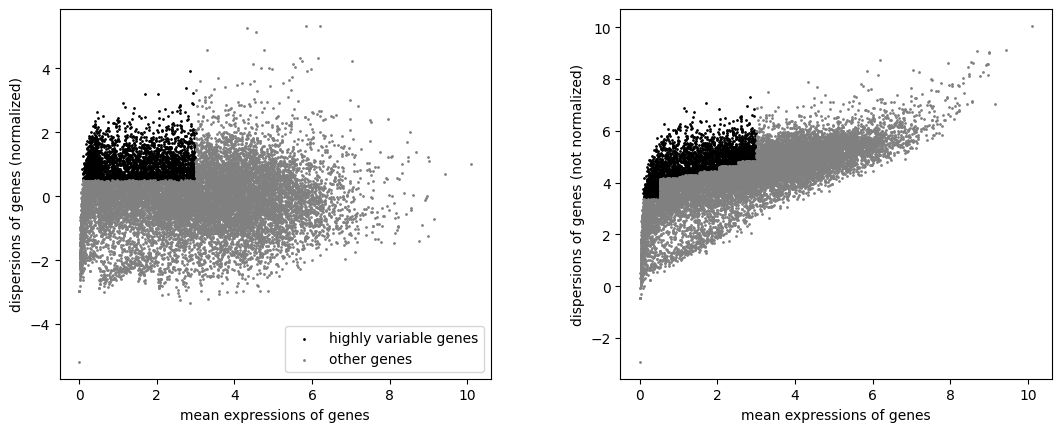

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
sc.tl.pca(adata)

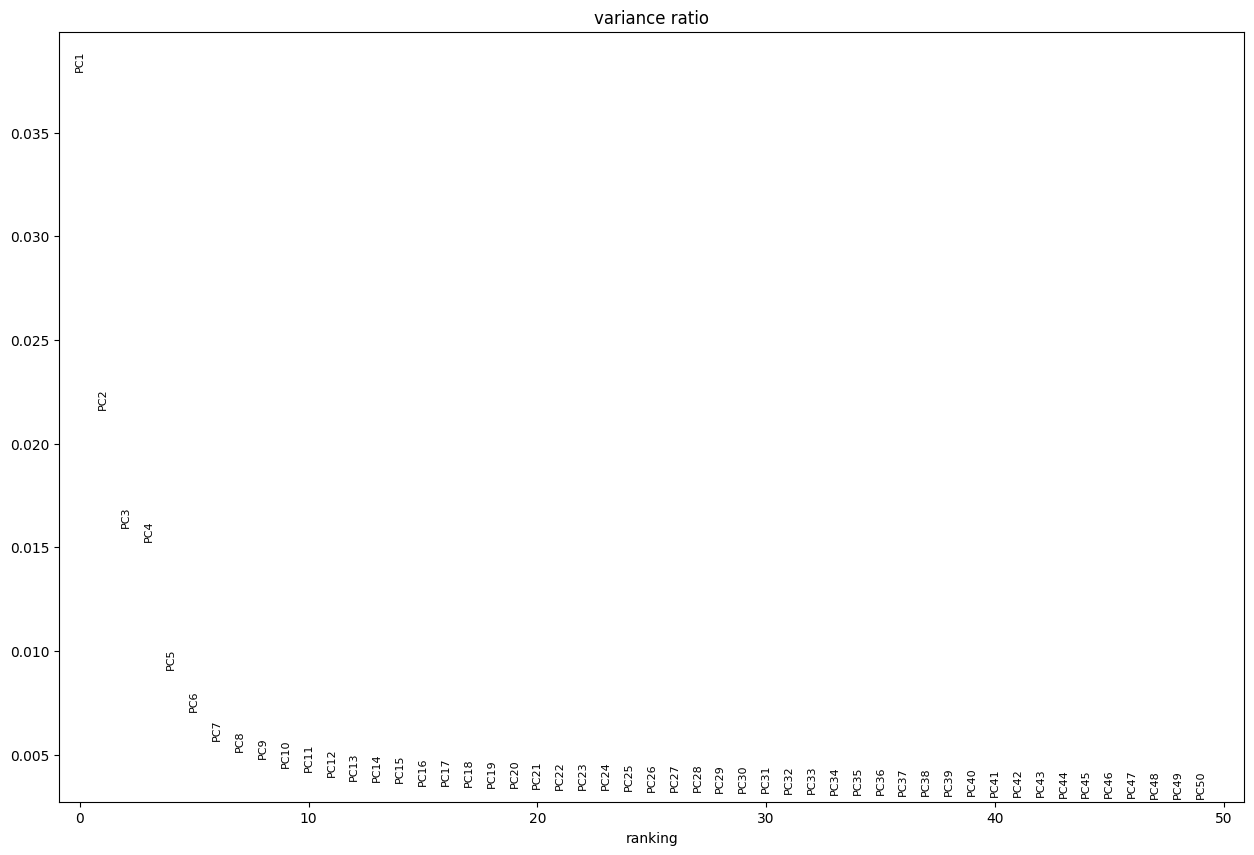

In [368]:
sc.pl.pca_variance_ratio(adata, n_pcs = 50)

In [369]:
adata.obsm['X_pca'].shape

(758, 50)

In [370]:
all_times = [0, 12, 24, 36, 72]
Xs_val = []
for time in all_times:
    thisstr = str(time)+"h"
    the_samples = np.array( [thisstr in x for x in sample_keys])
    Xs_val.append(adata.obsm['X_pca'][the_samples,:5]/10)

In [371]:
np.save("hESC_pca5.npy",arr = np.array(Xs_val))

 /state/partition1/slurm_tmp/26071450.0.0/ipykernel_2978600/342964402.py:1: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### Prepare things

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from TrajectoryNet.dataset import EBData

from SBIRR.SDE_solver import solve_sde_RK
from SBIRR.utils import plot_trajectories_2
from SBIRR.Schrodinger import gpIPFP, SchrodingerTrain, gpdrift, nndrift
from SBIRR.GP import spatMultitaskGPModel
from SBIRR.gradient_field_NN import train_nn_gradient, GradFieldMLP2
from SBIRR.booleansde import mrnabooleansde, nninputfun

import torch

from celluloid import Camera
from IPython.display import HTML
import math

In [5]:
Xs_val = np.load("hESC_pca5.npy",allow_pickle=True)
Xs_val = [torch.tensor(X) for X in Xs_val] # make list

In [6]:
device = "cpu"
torch.manual_seed(0)

In [10]:
# SDE Solver config
sigma = .05
dt = 0.025
N = int(math.ceil(1.0/dt))
#N = 21
#dt = 1/N
# IPFP init config
# prior_X_0 = torch.cat((X_0, X_1))
N_steps = 3
dts = np.array([0, 1, 3])  # should make irregular eventually 
Ns = np.ceil((dts[1:]-dts[:-1])/dt).astype(int)

In [11]:
Xs = [Xs_val[i] for i in [0,2,4]] # training

In [12]:
mySchrodinger_train = SchrodingerTrain(Xs, dts, sigma)
# IPFP worker
#myIPFP = gpIPFP(ref_drift = None, GPfun = sparseGPfun, N = N,device = device)
def gpIPFPmaker(ref_drift = None, N = N,device = device):
    return gpIPFP(ref_drift = ref_drift, N = N,device = device)

In [13]:
import torch.nn as nn
mynet = nn.Sequential(nn.Linear(5 , 128), 
                      nn.ReLU(), 
                      nn.Linear(128,64), 
                      nn.ReLU(), 
                      nn.Linear(64,64), 
                      nn.ReLU(), 
                      nn.Linear(64, 1))

mlp = GradFieldMLP2(net = mynet)
def train_nn_gradient_verbos(model, x_train, y_train_gradient):
    train_nn_gradient(model, x_train, y_train_gradient, optimizer = None,
                      epochs = 30, lr = 0.002,verbose=False)
mynndrift = nndrift(mlp.double(), train_nn_gradient_verbos, N = N)

In [14]:
# fit drift
IPFP_drift_fit, backnforth = mySchrodinger_train.iter_drift_fit(gpIPFPmaker,
                                                                mynndrift,
                                                                ipfpiter = 10, 
                                                                iteration = 10)


100%|██████████| 10/10 [12:49<00:00, 76.96s/it]


In [15]:
np.save("hesc_sbsde.npy", backnforth)

In [16]:
mySchrodinger_train_vSB = SchrodingerTrain(Xs, dts, sigma)

mynet_vSB = nn.Sequential(nn.Linear(5, 1, bias = False))
nn.init.constant_(mynet_vSB[0].weight, 0)
mlp_vSB = GradFieldMLP2(net = mynet_vSB)
mynndrift_vSB = nndrift(mlp_vSB.double(), train_nn_gradient, N = N)

# fit drift
_, backnforth_vSB = mySchrodinger_train_vSB.iter_drift_fit(gpIPFPmaker,mynndrift_vSB,
                                                        ipfpiter = 10, 
                                                        iteration = 1)

100%|██████████| 1/1 [01:06<00:00, 66.42s/it]


In [17]:
np.save("hesc_vsb.npy", backnforth_vSB)

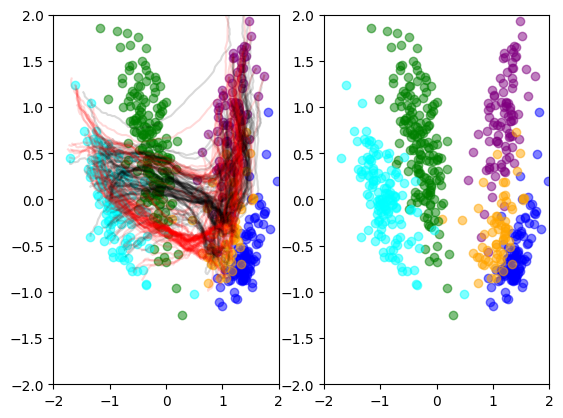

In [18]:
fig, ax = plt.subplots(1,2)
for i in range(2):
    ax[i].axis([-2, 2, -2, 2])

for i in range(100):
    ax[0].plot(backnforth_vSB.detach().numpy()[i,:,0], 
            backnforth_vSB.detach().numpy()[i,:,1], 
            alpha=0.15, color="black")
    
    ax[0].plot(backnforth.detach().numpy()[i,:,0], 
            backnforth.detach().numpy()[i,:,1], 
            alpha=0.15, color="red")
cols = ["purple", "blue", "orange", "green", "cyan"]
for axi in ax:
    for i in range(5):
        axi.scatter(Xs_val[i][:,0],Xs_val[i][:,1], c=cols[i], alpha=0.5)
    



In [19]:
from TrajectoryNet.optimal_transport.emd import earth_mover_distance

2024-05-16 12:37:01.044240: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 12:37:05.513675: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 12:37:26.938140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 12:39:02.734918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
traj = np.load("results/hesc_gpu_vscale.01_var.1/replaced_traj.npy")
traj_loc = traj[:,:,:5]
backnforth = np.load("hesc_sbsde.npy")
backnforth_vSB = np.load("hesc_vsb.npy")

In [21]:
i = 1
[earth_mover_distance(Xs_val[2 * i + 1], backnforth[:,int((backnforth.shape[1]-1)/(len(Xs_val)-1)) * (2 * i + 1),:-1]), \
earth_mover_distance(Xs_val[2 * i + 1], backnforth_vSB[:,int((backnforth.shape[1]-1)/(len(Xs_val)-1)) * (2 * i + 1),:-1]), \
earth_mover_distance(Xs_val[2 * i + 1], traj_loc[:,int((traj_loc.shape[1]-1)/(len(Xs_val)-1)) * (2 * i + 1),:])]

[1.3820984870378172, 1.241472455800177, 1.428653487869275]

In [22]:
i = 0
[earth_mover_distance(Xs_val[2 * i + 1], backnforth[:,int((backnforth.shape[1]-1)/(len(Xs_val)-1)) * (2 * i + 1),:-1]), \
earth_mover_distance(Xs_val[2 * i + 1], backnforth_vSB[:,int((backnforth.shape[1]-1)/(len(Xs_val)-1)) * (2 * i + 1),:-1]), \
earth_mover_distance(Xs_val[2 * i + 1], traj_loc[:,int((traj_loc.shape[1]-1)/(len(Xs_val)-1)) * (2 * i + 1),:])]

[0.6820310536254898, 0.7068443480313986, 1.2015446447591955]

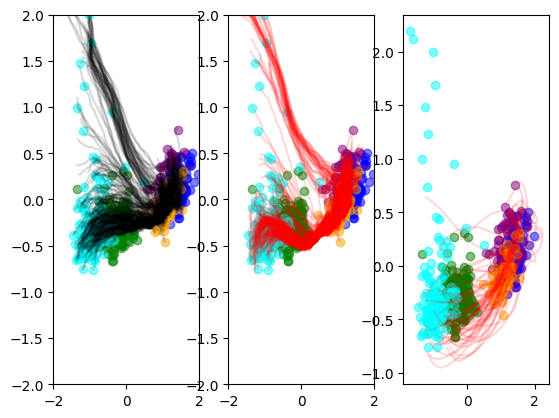

In [23]:
fig, ax = plt.subplots(1,3)
for i in range(2):
    ax[i].axis([-2, 2, -2, 2])

for i in range(296):
    ax[0].plot(backnforth_vSB[i,:,0], 
            backnforth_vSB[i,:,2], 
            alpha=0.15, color="black")
    
    ax[1].plot(backnforth[i,:,0], 
            backnforth[i,:,2], 
            alpha=0.15, color="red")

for i in range(66):
    ax[2].plot(traj_loc[i,:,0], 
            traj_loc[i,:,2], 
            alpha=0.15, color="red")
    
cols = ["purple", "blue", "orange", "green", "cyan"]
for axi in ax:
    for i in range(5):
        axi.scatter(Xs_val[i][:,0],Xs_val[i][:,2], c=cols[i], alpha=0.5)
    
